In [1]:
### Initiate Notebook with local imports ###
from helpers.async_logger import AsyncLogger
from helpers.pickler import Pickler
### Third-Party Packages ###
from pandas import read_csv, get_dummies
from matplotlib import pyplot
from numpy import square
pickler = Pickler.get_instance()
logger = AsyncLogger.get_instance('cancer_survival')
data = await pickler.load('radiomics_v2')
if data is None: data = read_csv('data/radiomics_v2.csv')

### Rename Columns with Black Space to use Underscores instead
renamed_cols = {
    col: '_'.join(col.split(' ')) for col in filter(lambda x: x[0]!='v', data.columns)
}
await logger.info(renamed_cols)
data.rename(columns=renamed_cols, inplace=True)
await logger.info(f'Data: {data.shape}')
await logger.info(f'Data Columns: {data.columns}')
await logger.info(f'Percentage of Null Data:\n{data.isnull().sum() / data.shape[0]}')

[INFO] {'Patient ID': 'Patient_ID', 'Gender': 'Gender', 'Age': 'Age', 'Clinical A': 'Clinical_A', 'Clinical B': 'Clinical_B', 'Clinical C': 'Clinical_C', 'Clinical D': 'Clinical_D', 'Time to Event': 'Time_to_Event', 'Patient Status': 'Patient_Status', 'Patient Status at 3 Year': 'Patient_Status_at_3_Year'}
[INFO] Data: (197, 852)
[INFO] Data Columns: Index(['Patient_ID', 'Gender', 'Age', 'Clinical_A', 'Clinical_B', 'Clinical_C',
       'Clinical_D', 'Time_to_Event', 'Patient_Status',
       'Patient_Status_at_3_Year',
       ...
       'v833', 'v834', 'v835', 'v836', 'v837', 'v838', 'v839', 'v840', 'v841',
       'v842'],
      dtype='object', length=852)
[INFO] Percentage of Null Data:
Patient_ID    0.0
Gender        0.0
Age           0.0
Clinical_A    0.0
Clinical_B    0.0
             ... 
v838          0.0
v839          0.0
v840          0.0
v841          0.0
v842          0.0
Length: 852, dtype: float64


[INFO] Clinical A Values: 2    73
3    48
1    44
4    32
Name: Clinical_A, dtype: int64
[INFO] Clinical A Null Value Percentage: 0.0


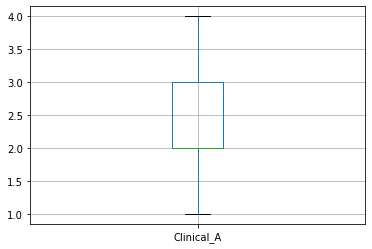

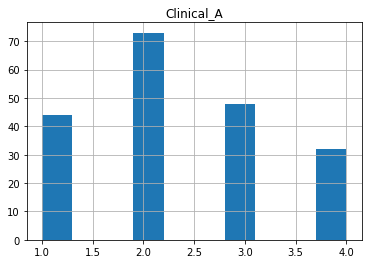

In [2]:
### Checks Clinical_A Column for anomalies ###
await logger.info(f'Clinical A Values: {data.Clinical_A.value_counts()}')
await logger.info(f'Clinical A Null Value Percentage: {data.Clinical_A.isnull().any() / data.shape[0]}')
data.boxplot(['Clinical_A'])
data.hist(['Clinical_A'])
pyplot.show()

[INFO] Clinical B Values: 2    97
1    48
3    46
0     6
Name: Clinical_B, dtype: int64
[INFO] Clinical B Null Value Percentage: 0.0


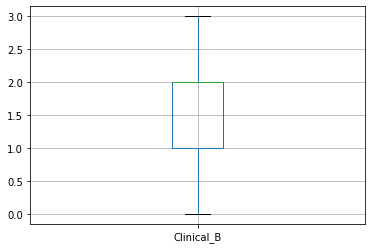

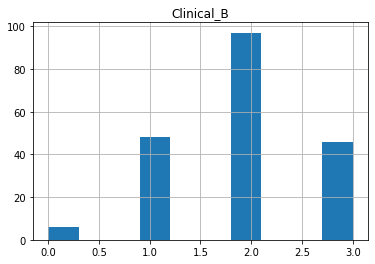

In [3]:
### Checks Clinical_B Column for anomalies ###
await logger.info(f'Clinical B Values: {data.Clinical_B.value_counts()}')
await logger.info(f'Clinical B Null Value Percentage: {data.Clinical_B.isnull().any() / data.shape[0]}')
data.boxplot(['Clinical_B'])
data.hist(['Clinical_B'])
pyplot.show()

[INFO] Clinical C Values: 3    97
4    71
2    28
1     1
Name: Clinical_C, dtype: int64
[INFO] Clinical C Null Value Percentage: 0.0


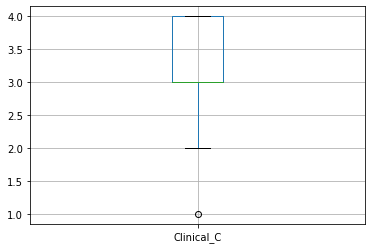

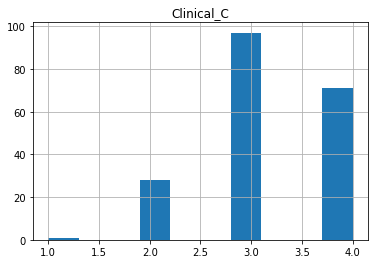

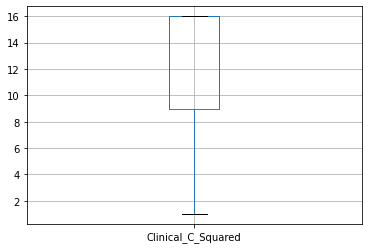

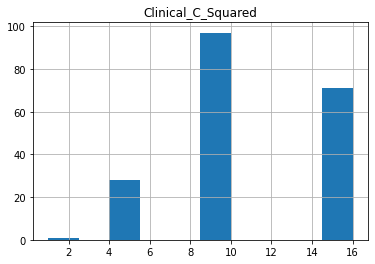

In [4]:
### Checks Clinical_C Column for anomalies ###
await logger.info(f'Clinical C Values: {data.Clinical_C.value_counts()}')
await logger.info(f'Clinical C Null Value Percentage: {data.Clinical_C.isnull().any() / data.shape[0]}')
data.boxplot(['Clinical_C'])
data.hist(['Clinical_C'])
pyplot.show()

### Clinical_C looks skewed, must be corrected using Square Values ###
from numpy import square
data['Clinical_C_Squared'] = square(data.Clinical_C)
data.boxplot(['Clinical_C_Squared'])
data.hist(['Clinical_C_Squared'])
pyplot.show()

### Looks Good, now drop original Clinical_C column ###
data.drop(['Clinical_C'], axis=1, inplace=True)

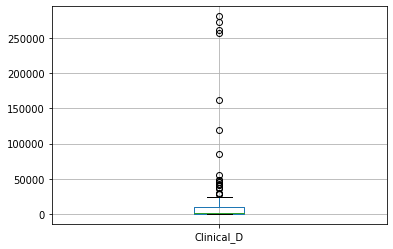

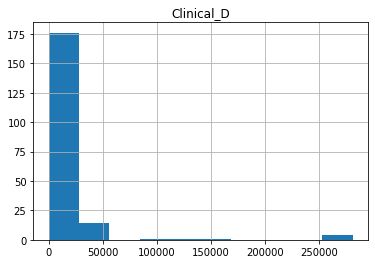

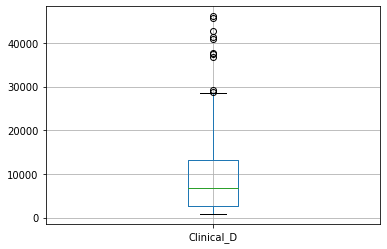

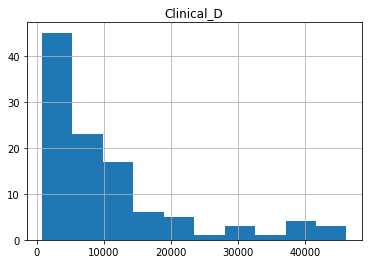

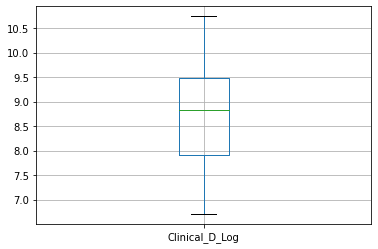

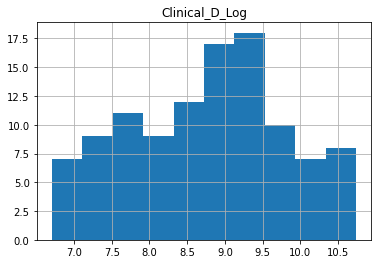

In [5]:
### Checks Clinical_D Column for anomalies ###
# await logger.info(f'Clinical D Values: {data.Clinical_D.value_counts()}')
# await logger.info(f'Clinical D Null Value Percentage: {data.Clinical_D.isnull().any() / data.shape[0]}')
data.boxplot(['Clinical_D'])
data.hist(['Clinical_D'])
pyplot.show()
### Clinical_D seems to have an outlying tail in the positive ###
### Remove Outliers ###
data = data[(data.Clinical_D < data.Clinical_D.quantile(.95)) & (data.Clinical_D > 0)]
data.boxplot(['Clinical_D'])
data.hist('Clinical_D')
pyplot.show()
### Still Skewed, try Logarithmic Function ###
from numpy import log
data['Clinical_D_Log'] = log(data.Clinical_D)
data.boxplot(['Clinical_D_Log'])
data.hist('Clinical_D_Log')
pyplot.show()

### Looks Good, now drop original Clinical_D column ###
data.drop(['Clinical_D'], axis=1, inplace=True)

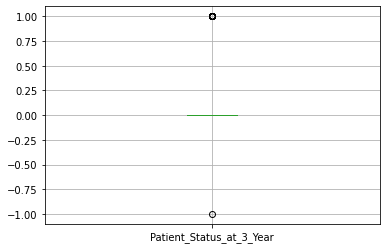

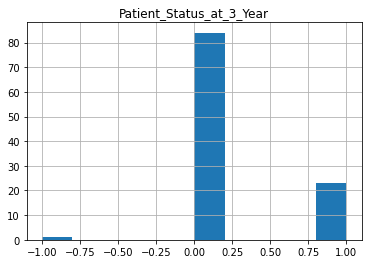

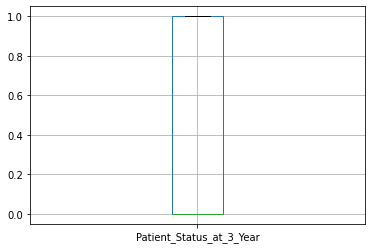

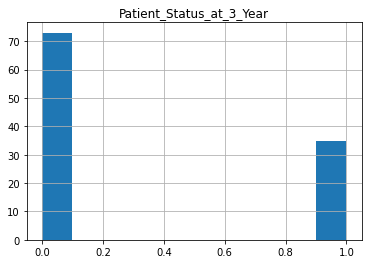

In [6]:
### Checks Patient_Status_at_3_Year Column for anomalies ###
# await logger.info(f'Patient_Status_at_3_Year Values: {data.Clinical_D.value_counts()}')
# await logger.info(f'Patient_Status_at_3_Year Null Value Percentage: {data.Clinical_D.isnull().any() / data.shape[0]}')
data.boxplot(['Patient_Status_at_3_Year'])
data.hist(['Patient_Status_at_3_Year'])
pyplot.show()
### When Patient_Status_at_3_Year is unknown, impute with last known data ###
data['Patient_Status_at_3_Year'] = data[['Patient_Status_at_3_Year', 'Patient_Status']].max(1)
data.boxplot(['Patient_Status_at_3_Year'])
data.hist('Patient_Status_at_3_Year')
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119fba860>]],
      dtype=object)

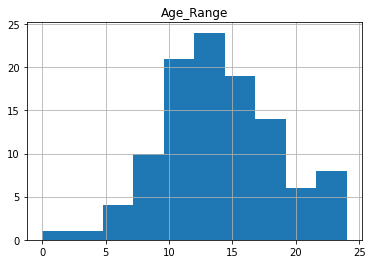

In [7]:
### Remove invalid rows from with 0 Age
data = data[(data['Age'] > 0)]
### Bin Age to Age Range ###
from pandas import cut
age_range = 3
num_bins = int(data.Age.max() / age_range)
data['Age_Range'] = cut(data['Age'], num_bins, labels=False)
data.drop(['Age'], axis=1, inplace=True)
data.hist(['Age_Range'])

In [8]:
### Logs Final Shape and Columns before Regression ###
await logger.info(f'Test Data: {data.shape}')
await logger.info(f'Test Data Columns: {data.columns}')
await logger.info(f'Percentage of Null Data:\n{data.isnull().sum() / data.shape[0]}')

[INFO] Test Data: (108, 852)
[INFO] Test Data Columns: Index(['Patient_ID', 'Gender', 'Clinical_A', 'Clinical_B', 'Time_to_Event',
       'Patient_Status', 'Patient_Status_at_3_Year', 'v1', 'v2', 'v3',
       ...
       'v836', 'v837', 'v838', 'v839', 'v840', 'v841', 'v842',
       'Clinical_C_Squared', 'Clinical_D_Log', 'Age_Range'],
      dtype='object', length=852)
[INFO] Percentage of Null Data:
Patient_ID            0.0
Gender                0.0
Clinical_A            0.0
Clinical_B            0.0
Time_to_Event         0.0
                     ... 
v841                  0.0
v842                  0.0
Clinical_C_Squared    0.0
Clinical_D_Log        0.0
Age_Range             0.0
Length: 852, dtype: float64


In [9]:
### Train Model ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

trainable_data = data[data.Patient_Status_at_3_Year.notna()]
x_train = trainable_data.drop(['Patient_ID', 'Time_to_Event', 'Patient_Status', 'Patient_Status_at_3_Year'], axis=1)
y_train = trainable_data['Patient_Status_at_3_Year']
y_stratify = trainable_data['Gender'] * y_train
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=.8, stratify=y_stratify)
model.fit(x_train, y_train)
await logger.info(model)

[INFO] RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [10]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
y_predict = model.predict(x_test)
num_wrong_predictions = (y_predict != y_test).sum()
r2 = r2_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = sqrt(mse)
await logger.info(f'Number of Wrong Predictions: {num_wrong_predictions} / {len(y_predict)}')
await logger.info(f'R2: {r2:.4f}')
await logger.info(f'Mean Squared Error: {mse:.4f}')
await logger.info(f'Root Mean Squared Error: {rmse:.4f}')

[INFO] Number of Wrong Predictions: 9 / 22
[INFO] R2: -0.8857
[INFO] Mean Squared Error: 0.4091
[INFO] Root Mean Squared Error: 0.6396
